<a href="https://colab.research.google.com/github/ReaganJHarris/ET_Retrieval/blob/main/ETmetric_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression as LinRegr
from scipy import stats
import datetime as dt
from collections import defaultdict
from scipy.stats import norm
import tensorflow as tf
from scipy.stats import entropy
from scipy.special import rel_entr, kl_div

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
#Landsat Type
# Landsat_Type = 5
# Landsat_Type = 7
Landsat_Type = 8

In [ ]:
CO_counties = ['Denver', 'Elbert', 'Gilpin', 'Moffat', 'Phillips', 'San_Juan']

# Landsat 8

In [ ]:
#@title Actual ET files
path = ('/gdrive/MyDrive/ET_cCoef_trials/ET_retrieval_Metrics/')

metric_years = np.arange(2018, 2013, -1) #Ls8
# metric_years = np.arange(2013, 2011, -1) #Ls7
# metric_years = np.arange(2011, 1999, -1) #Ls5
# metric_years = np.arange(2018, 1999, -1) #full range

metricFiles = []

for counties in CO_counties:
  counties = str(counties)
  for year in metric_years:
    year_str = str(year)
# for year in metric_years:
#   year_str = str(year)
#   for counties in CO_counties:
    try:
      metricPath = ('Metrics_table_' + counties + '_' + year_str + '.csv')
      filepath = os.path.join(path, year_str, metricPath)
      # print(filepath)
      # print ("Is it File?" + str(os.path.isfile(filepath)))
      countyfile = pd.read_csv(filepath)
      countyfile['County'] = counties
      #Return the size, in bytes, of path. 
      # if os.stat(filepath).st_size > 1:
      # metricFiles.append(pd.read_csv(filepath))
      metricFiles.append(countyfile)
      # metricFiles.append(filepath)
    except:
      pass

merged_df = pd.concat(metricFiles, ignore_index=True)

merged_df.drop(columns=['.geo', 'system:index'], inplace=True)
# merged_df

In [ ]:
#@title Remove outliers based on std of specific columns and iterate the process enough time to exclude all outliers

merged_wo_outliers_df = merged_df
bad_outliers_df = []

max_iteration = 5
for iter in list(range(max_iteration)):
  print('Iter', iter)
  #step 1: get mean/std of mean_retrieved_ET across all counties in all years
  mean_meanRetrievedET = merged_wo_outliers_df['max_retrieved_ET'].mean()
  std_meanRetrievedET = merged_wo_outliers_df['max_retrieved_ET'].std()
  #step 2: determine the max threshold
  threshold_Max_retrievedET = mean_meanRetrievedET + (2*std_meanRetrievedET)
  #step 3: get index of good/bad rows based on max threshold
  indicators_goodRows = merged_wo_outliers_df['max_retrieved_ET'] < threshold_Max_retrievedET
  #step 4: remove bad rows from dataframe if points are above max threshold otherwise stop the iteration becasue all rows are good
  print(merged_wo_outliers_df['max_retrieved_ET'].count())
  print(indicators_goodRows.sum())
  if indicators_goodRows.sum() == merged_wo_outliers_df['max_retrieved_ET'].count():
    break
  else:
    bad_outliers_df.append(merged_wo_outliers_df.iloc[np.logical_xor(np.array(indicators_goodRows.to_list()), np.array([True]))])
    merged_wo_outliers_df = merged_wo_outliers_df.iloc[indicators_goodRows.to_list()]

merged_wo_outliers_df = merged_wo_outliers_df.reset_index()
merged_wo_outliers_df = merged_wo_outliers_df.drop(columns='index', index=[25,263])
# merged_wo_outliers_df.groupby(['County']).groups.keys()
# df['year'] = df['datetime_utc'].dt.year
# df_1['Date_string'] = df_1['Date_string'].astype('datetime64[ns]')
merged_wo_outliers_df['Date_string'] = merged_wo_outliers_df['Date_string'].astype('datetime64[ns]')
merged_wo_outliers_df['Year'] = merged_wo_outliers_df['Date_string'].dt.year
merged_wo_outliers_df['Month'] = merged_wo_outliers_df['Date_string'].dt.month

# Add Season column
season_conditions = [
      (merged_wo_outliers_df['Month'] <= 3),
      (merged_wo_outliers_df['Month'] > 3) & (merged_wo_outliers_df['Month'] <= 6),
      (merged_wo_outliers_df['Month'] > 6) & (merged_wo_outliers_df['Month'] <= 9),
      (merged_wo_outliers_df['Month'] > 9) & (merged_wo_outliers_df['Month'] <= 12)
]

seasons = ['Winter', 'Spring', 'Summer', 'Fall']

merged_wo_outliers_df['Season'] = np.select(season_conditions, seasons)

# merged_wo_outliers_df

Iter 0
343
341
Iter 1
341
339
Iter 2
339
336
Iter 3
336
322
Iter 4
322
311


In [ ]:
if Landsat_Type == 5:
  col_std_ARD = 'Std_Dev_ARD'
  col_mean_ARD = 'mean_ARD'
  col_mean_ET = 'mean_retrieved_ET'

elif Landsat_Type == 7:
  col_std_ARD = 'Std_Dev_ARD'
  col_mean_ARD = 'mean_ARD'

elif Landsat_Type == 8:
  col_std_ARD = 'Std_Dev_ARD8'
  col_mean_ARD = 'mean_ARD8'


0.24205051741403644 1.338230894207211 0.2448965499626837 0.08326704374221582 0.1368973897191779


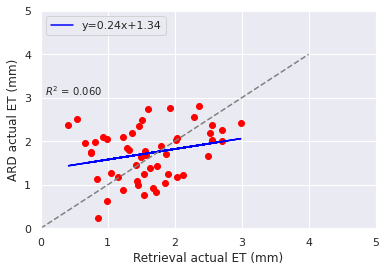

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [ ]:
# ARD and retreival linear regression plot by monthly, seasonal, and annual averages

Ls8_ETa_df = merged_wo_outliers_df


ETa_Yr_Mo_agg = Ls8_ETa_df.groupby(['Year', 'Month']).agg({'mean_ARD8': ['mean'], 'mean_retrieved_ET':['mean']}).reset_index()
ETa_Yr_Mo_agg.columns= [' '.join(col).strip() for col in ETa_Yr_Mo_agg.columns.values]
ETa_Yr_Mo_agg = ETa_Yr_Mo_agg.rename(columns={'mean_ARD8 mean': 'mean_ARD8', 'mean_retrieved_ET mean': 'mean_retrieved_ET'})
# ETa_Yr_Mo_agg

X=ETa_Yr_Mo_agg['mean_retrieved_ET'].values.reshape(-1,1) # this  has shape (XXX, 1) - it's 2D
Y=ETa_Yr_Mo_agg['mean_ARD8'].values.reshape(-1,1) # this  has shape (XXX, 1) - it's 2D
X1 = ETa_Yr_Mo_agg['mean_retrieved_ET'].values.tolist()
Y1 = ETa_Yr_Mo_agg['mean_ARD8'].values.tolist()
# print(X1)
spearsman_corr = stats.spearmanr(X1, Y1)
# print(spearsman_corr[0])
regress = LinRegr().fit(X,Y)
# fig1 = plt.figure(figsize=(5,5), dpi=600)
# fig1 = plt.figure()
plt.scatter(X, Y, color= 'red')
slope, intercept, r_value, p_value, std_err = stats.linregress(X1,Y1)
print(slope, intercept, r_value, p_value, std_err)
plt.annotate("$R^2$ = {:.3f}".format(r_value**2), (0.06, 3.06))
plt.plot(X, regress.predict(X), color = 'blue', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
# print(r_value)
plt.plot([0,4],[0,4], '--', color='gray')
plt.legend(loc='upper left')
# plt.title('Landsat 8 ARD ET vs Retrieval ET')
plt.xlabel('Retrieval actual ET (mm)')
plt.ylabel('ARD actual ET (mm)')
plt.ylim(0,5)
plt.xlim(0,5)
plt.show()
plt.figure(figsize=[5,5])
# print('R_square =', regress.score(X, Y))
# fig1.savefig('/gdrive/MyDrive/ET_report_figs/Ls8_Annual_Monthly_scatter.png')
# ETa_Yr_Mo_agg

,Year,mean_ARD8,mean_retrieved_ET
,,mean,mean
0,2014,1.977096,1.710197
1,2015,1.792253,1.925686
2,2016,1.818595,1.652741
3,2017,1.539588,1.545644
4,2018,1.648574,1.638424


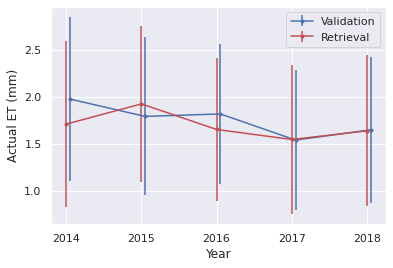

In [ ]:
# ARD ETa and Retrieval ETa overlaid with error bars

# Ls8_ARD_Ret_ETa_err = plt.figure(figsize=(5,5), dpi=600)
Ls_std_df = merged_wo_outliers_df.groupby('Year').agg({'Std_Dev_ARD8': ['mean'], 'Std_Dev_retrieved_ET': ['mean']})
Ls_mean_df = merged_wo_outliers_df.groupby('Year').agg({'mean_ARD8': ['mean'], 'mean_retrieved_ET': ['mean']})
# plt.plot(Ls_mean_df, linestyle='-', marker='o')
# plt.errorbar(Ls_mean_df['Year'], Ls_mean(ARD_mean))
Ls_mean_df = Ls_mean_df.reset_index()
Ls_mean_df.columns
Ls_std_df = Ls_std_df.reset_index()
Ls_std_df['Std_Dev_ARD8']['mean']
plt.errorbar(Ls_mean_df['Year'].add(.05), Ls_mean_df['mean_ARD8']['mean'], yerr=Ls_std_df['Std_Dev_ARD8']['mean'], color= 'b', fmt='.-') #ARD
plt.errorbar(Ls_mean_df['Year'], Ls_mean_df['mean_retrieved_ET']['mean'], yerr=Ls_std_df['Std_Dev_retrieved_ET']['mean'], color='r', fmt='.-') #ET
plt.xticks(np.arange(2014, 2019, 1))
plt.legend(('Validation', 'Retrieval'))
plt.ylabel('Actual ET (mm)')
plt.xlabel('Year')
# Ls8_ARD_Ret_ETa_err.set_title('Title', x=2, y=2)
# Ls8_ARD_Ret_ETa_err.savefig('/gdrive/MyDrive/ET_report_figs/Ls8_ARDandRet_ETa.png')
Ls_mean_df

<ErrorbarContainer object of 3 artists>

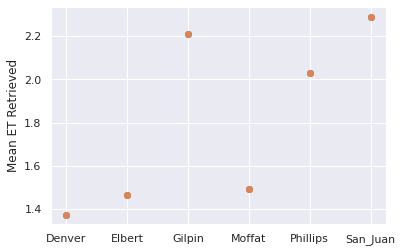

In [ ]:
# Default dictionary for Std Dev by County

from collections import defaultdict
#pull needed data from sataframe into series
meanET_Std_byCounty = merged_wo_outliers_df.groupby('County')['mean_retrieved_ET'].mean().reset_index().values.tolist()
meanET_Std_byCounty

#create default dict
d = defaultdict(list)

#create for loop to append data to default dict
for k, v in meanET_Std_byCounty:
  #append keys and values to dictionary
  d[k].append(v)

# sorted(d.items())
#plot default dictionary 
plt.plot(list(d.keys()),list(d.values()), 'o')
plt.ylabel('Mean ET Retrieved')

plt.errorbar(list(d.keys()),list(d.values()), fmt='o')

[[2014.0, 1.9770956916184732], [2015.0, 1.792252921399073], [2016.0, 1.818595476777349], [2017.0, 1.539587865183133], [2018.0, 1.6485738499651914], [2014.0, 1.710197455147836], [2015.0, 1.9256864674821805], [2016.0, 1.6527407258318079], [2017.0, 1.5456441289286482], [2018.0, 1.6384240803254528]]


([<matplotlib.axis.XTick at 0x7f688ef3a9d0>,
 <a list of 5 Text major ticklabel objects>)

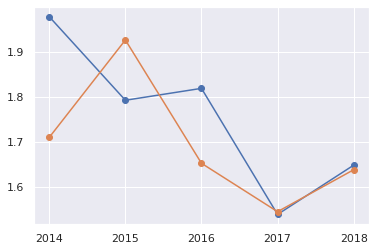

In [ ]:
# County avergaes over the 19 year range

x = merged_wo_outliers_df.groupby(['Year']).agg({'mean_ARD8': ['mean']}).reset_index().values.tolist()
# print(x)
y = merged_wo_outliers_df.groupby(['Year']).agg({'mean_retrieved_ET': ['mean']}).reset_index().values.tolist()
# print(y)
# y = merged_wo_outliers_df.groupby(['County', 'Year']).agg({'ARD_mean': ['mean']}).drop(columns='ARD_mean').reset_index().values.tolist()
# print(y)
z_list = x + y
print(z_list)
# print(z_list)
dd = defaultdict(list)
for k, v in z_list:
 dd[k].append(v)

# sorted(dd.items())
plt.plot(list(dd.keys()),list(dd.values()), linestyle='-', marker='o')
plt.xticks(np.arange(2014,2019,1))

# Landsat 7

In [ ]:
#@title Actual ET Landsat 7

Ls7_metric_folder_path = ('/gdrive/MyDrive/ET_cCoef_trials/ET_retrieval_Metrics/')

yr_range_metrics = np.arange(2012, 2014, 1)

metric_files = []

for counties in CO_counties:
  counties = str(counties)
  for year in yr_range_metrics:
    year_str = str(year)
    try:
      metricPath = ('Metrics_table_' + counties + '_' + year_str + '.csv')
      filepath = os.path.join(Ls7_metric_folder_path, year_str, metricPath)
      # print(filepath)
      # print ("Is it a file? " + str(os.path.isfile(filepath)))

      countyfile = pd.read_csv(filepath)
      countyfile['County'] = counties

      metric_files.append(countyfile)

    except:
      pass

Ls7_raw_df = pd.concat(metric_files, ignore_index=True)

Ls7_raw_df.drop(columns=['.geo', 'system:index'], inplace=True)

# Ls7_raw_df

In [ ]:
#@title Remove outliers based on std of specific columns and iterate the process enough time to exclude all outliers

Ls7_Wo_outliers = Ls7_raw_df
bad_outliers_df = []

max_iteration = 3
for iter in list(range(max_iteration)):
  print('Iter', iter)
  #step 1: get mean/std of mean_retrieved_ET across all counties in all years
  mean_meanRetrievedET = Ls7_Wo_outliers['max_retrieved_ET'].mean()
  std_meanRetrievedET = Ls7_Wo_outliers['max_retrieved_ET'].std()
  #step 2: determine the max threshold
  threshold_Max_retrievedET = mean_meanRetrievedET + (2*std_meanRetrievedET)
  #step 3: get index of good/bad rows based on max threshold
  indicators_goodRows = Ls7_Wo_outliers['max_retrieved_ET'] < threshold_Max_retrievedET
  #step 4: remove bad rows from dataframe if points are above max threshold otherwise stop the iteration becasue all rows are good
  print(Ls7_Wo_outliers['max_retrieved_ET'].count())
  print(indicators_goodRows.sum())
  if indicators_goodRows.sum() == Ls7_Wo_outliers['max_retrieved_ET'].count():
    break
  else:
    bad_outliers_df.append(Ls7_Wo_outliers.iloc[np.logical_xor(np.array(indicators_goodRows.to_list()), np.array([True]))])
    Ls7_Wo_outliers = Ls7_Wo_outliers.iloc[indicators_goodRows.to_list()]

# merged_wo_outliers_df['max_retrieved_ET'].std()
# merged_wo_outliers_df.groupby(['County']).groups.keys()
# df['year'] = df['datetime_utc'].dt.year
# df_1['Date_string'] = df_1['Date_string'].astype('datetime64[ns]')
Ls7_Wo_outliers['Date_string'] = Ls7_Wo_outliers['Date_string'].astype('datetime64[ns]')
Ls7_Wo_outliers['Year'] = Ls7_Wo_outliers['Date_string'].dt.year
Ls7_Wo_outliers['Month'] = Ls7_Wo_outliers['Date_string'].dt.month

# Add Season column
season_conditions = [
      (Ls7_Wo_outliers['Month'] <= 3),
      (Ls7_Wo_outliers['Month'] > 3) & (Ls7_Wo_outliers['Month'] <= 6),
      (Ls7_Wo_outliers['Month'] > 6) & (Ls7_Wo_outliers['Month'] <= 9),
      (Ls7_Wo_outliers['Month'] > 9) & (Ls7_Wo_outliers['Month'] <= 12)
]

seasons = ['Winter', 'Spring', 'Summer', 'Fall']

Ls7_Wo_outliers['Season'] = np.select(season_conditions, seasons)
Ls7_Wo_outliers = Ls7_Wo_outliers.reset_index()
Ls7_Wo_outliers = Ls7_Wo_outliers.drop(columns='index')
Ls7_Wo_outliers = Ls7_Wo_outliers.drop(index=[130])

# Ls7_Wo_outliers

Iter 0
158
157
Iter 1
157
156
Iter 2
156
154


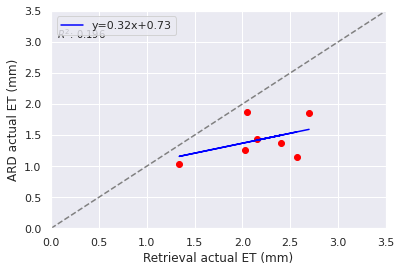

In [ ]:
# ARD and retreival ETa linear regression for monthly, seasonal, and annual averages
Ls7_ETa_df = Ls7_Wo_outliers

ETa_yr_mo_df = Ls7_ETa_df.groupby(['Year', 'Season']).agg({'mean_ARD': ['mean'], 'mean_retrieved_ET':['mean']}).reset_index()
ETa_yr_mo_df.columns= [' '.join(col).strip() for col in ETa_yr_mo_df.columns.values]
ETa_yr_mo_df = ETa_yr_mo_df.rename(columns={'mean_ARD mean': 'mean_ARD', 'mean_retrieved_ET mean': 'mean_retrieved_ET'})
# ETa_yr_mo_df

# y_pred = regressor.predict(x)
X=ETa_yr_mo_df['mean_retrieved_ET'].values.reshape(-1,1) # this  has shape (XXX, 1) - it's 2D
Y=ETa_yr_mo_df['mean_ARD'].values.reshape(-1,1) # this  has shape (XXX, 1) - it's 2D
X1 = ETa_yr_mo_df['mean_retrieved_ET'].values.tolist()
Y1 = ETa_yr_mo_df['mean_ARD'].values.tolist()
# print(X1)
# fig3 = plt.figure(figsize=(5,5), dpi=600)
# fig3 = plt.figure()
regress = LinRegr().fit(X,Y)
plt.scatter(X, Y, color= 'red')
slope, intercept, r_value, p_value, std_err = stats.linregress(X1,Y1)
plt.plot(X, regress.predict(X), color = 'blue', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
# print(slope)
plt.plot([0,3.5],[0,3.5], '--', color='gray')
plt.legend(loc='upper left')
plt.annotate('$R^2$: {:.3f}'.format(r_value**2), (0.06, 3.06))
# plt.title('Landsat 7 Seasonal ET', x=0.26, y=0.92)
plt.xlabel('Retrieval actual ET (mm)')
plt.ylabel('ARD actual ET (mm)')
plt.ylim(0,3.5)
plt.xlim(0,3.5)
plt.show()

# fig3.savefig('/gdrive/MyDrive/ET_report_figs/Ls7_Annual_Monthly_scatter.png')
# ETa_yr_mo_df

Text(0, 0.5, 'Actual ET (mm)')

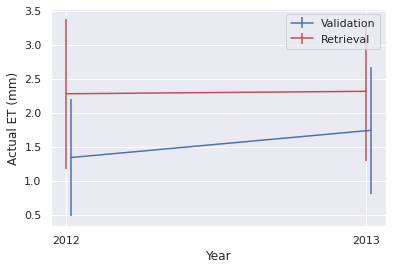

In [ ]:
# ARD ETa and Retrieval ETa overlaid with error bars

# Ls7_ARD_Ret_ETa_err = plt.figure(figsize=(5,5), dpi=600)
Ls7_std_df = Ls7_ETa_df.groupby('Year').agg({'Std_Dev_ARD': ['mean'], 'Std_Dev_retrieved_ET': ['mean']})
Ls7_mean_df = Ls7_ETa_df.groupby('Year').agg({'mean_ARD': ['mean'], 'mean_retrieved_ET': ['mean']})
# plt.plot(Ls_mean_df, linestyle='-', marker='o')
# plt.errorbar(Ls_mean_df['Year'], Ls_mean(ARD_mean))
Ls7_mean_df = Ls7_mean_df.reset_index()
Ls7_mean_df.columns
Ls7_std_df = Ls7_std_df.reset_index()
Ls7_std_df['Std_Dev_ARD']['mean']
plt.errorbar(Ls7_mean_df['Year'].add(.015), Ls7_mean_df['mean_ARD']['mean'], yerr=Ls7_std_df['Std_Dev_ARD']['mean'], color= 'b') #ARD
plt.errorbar(Ls7_mean_df['Year'], Ls7_mean_df['mean_retrieved_ET']['mean'], yerr=Ls7_std_df['Std_Dev_retrieved_ET']['mean'], color='r') #ET
plt.xticks(np.arange(2012, 2014, 1))
plt.legend(('Validation', 'Retrieval'))
plt.xlabel('Year')
plt.ylabel('Actual ET (mm)')
# Ls7_ARD_Ret_ETa_err.savefig('/gdrive/MyDrive/ET_report_figs/Ls7_ARDandRet_ETa.png')

# Landsat 5

In [ ]:
#@title Actual ET files Landsat 5

ETa_metric_files = []

ETa_metric_path = ('/gdrive/MyDrive/ET_cCoef_trials/ETa_wSeasonal_c/')
range_yrs = np.arange(2011, 1999, -1)

for counties in CO_counties:
  counties = str(counties)
  for year in range_yrs:
    year_str = str(year)

    try:
      metricPath = ('Metrics_table_' + counties + '_' + year_str + '.csv')
      filepath = os.path.join(ETa_metric_path, metricPath)
      # print(filepath)
      # print("Is it File?" + str(os.path.isfile(filepath)))
      countyfile = pd.read_csv(filepath)
      countyfile['County'] = counties

      ETa_metric_files.append(countyfile)

    except:
      pass

ETa_concat_df = pd.concat(ETa_metric_files, ignore_index=True)

ETa_concat_df.drop(columns=['.geo', 'system:index'], inplace=True)
# ETa_concat_df

In [ ]:
#@title Remove outliers based on std of specific columns and iterate the process enough time to exclude all outliers

ETa_outliers_df = ETa_concat_df
bad_outliers_df = []

max_iteration = 3
for iter in list(range(max_iteration)):
  print('Iter', iter)
  #step 1: get mean/std of mean_retrieved_ET across all counties in all years
  mean_meanRetrievedET = ETa_outliers_df['max_retrieved_ET'].mean()
  std_meanRetrievedET = ETa_outliers_df['max_retrieved_ET'].std()
  #step 2: determine the max threshold
  threshold_Max_retrievedET = mean_meanRetrievedET + (2*std_meanRetrievedET)
  #step 3: get index of good/bad rows based on max threshold
  indicators_goodRows = ETa_outliers_df['max_retrieved_ET'] < threshold_Max_retrievedET
  #step 4: remove bad rows from dataframe if points are above max threshold otherwise stop the iteration becasue all rows are good
  print(ETa_outliers_df['max_retrieved_ET'].count())
  print(indicators_goodRows.sum())
  if indicators_goodRows.sum() == ETa_outliers_df['max_retrieved_ET'].count():
    break
  else:
    bad_outliers_df.append(ETa_outliers_df.iloc[np.logical_xor(np.array(indicators_goodRows.to_list()), np.array([True]))])
    ETa_outliers_df = ETa_outliers_df.iloc[indicators_goodRows.to_list()]


ETa_outliers_df['Date_string'] = ETa_outliers_df['Date_string'].astype('datetime64[ns]')
ETa_outliers_df['Year'] = ETa_outliers_df['Date_string'].dt.year
ETa_outliers_df['Month'] = ETa_outliers_df['Date_string'].dt.month

# Add Season column
season_conditions = [
      (ETa_outliers_df['Month'] <= 3),
      (ETa_outliers_df['Month'] > 3) & (ETa_outliers_df['Month'] <= 6),
      (ETa_outliers_df['Month'] > 6) & (ETa_outliers_df['Month'] <= 9),
      (ETa_outliers_df['Month'] > 9) & (ETa_outliers_df['Month'] <= 12)
]

seasons = ['Winter', 'Spring', 'Summer', 'Fall']

ETa_outliers_df['Season'] = np.select(season_conditions, seasons)
# ETa_outliers_df.to_csv('ETa_daily_2000.csv')
# ETa_outliers_df

Iter 0
875
870
Iter 1
870
870


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
#@title ET uncertainty files
# CO_counties = ['Denver', 'Elbert', 'Gilpin', 'Moffat', 'Phillips', 'San_Juan']
# CO_counties = ['Phillips']

ETunFolder_path = ('/gdrive/MyDrive/ETun_Seasonal_Metrics/')

metric_yr_range = np.arange(2011, 1999, -1)

metric_files = []

for counties in CO_counties:
  counties = str(counties)
  for year in metric_yr_range:
    year_str = str(year)
    try:
      metricPath = ('Metrics_table_' + counties + '_' + year_str + '.csv')
      filepath = os.path.join(ETunFolder_path, metricPath)
      # print(filepath)
      # print ("Is it a file? " + str(os.path.isfile(filepath)))

      countyfile = pd.read_csv(filepath)
      countyfile['County'] = counties

      metric_files.append(countyfile)

    except:
      pass

concat_ETun_df = pd.concat(metric_files, ignore_index=True)

concat_ETun_df.drop(columns=['.geo', 'system:index'], inplace=True)

# concat_ETun_df

## ARD ET and Retreival ET linear regression

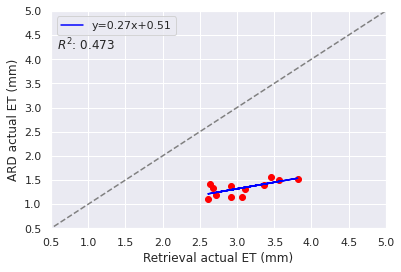

array([3.45357456, 3.36681881, 2.91708502, 3.06661235, 2.67882343,
       2.63269375, 2.60819583, 3.81396509, 2.71785196, 3.56631648,
       2.92245363, 3.11267582])

In [ ]:
ETa_stats_df = ETa_outliers_df

# grouper = pd.Grouper(key='Date_string', freq='M')
# ETa_outliers_df = ETa_outliers_df.groupby(grouper)[['mean_ARD', 'mean_retrieved_ET']].mean().reset_index()
# ETa_outliers_df = ETa_outliers_df.dropna()
# print(merged_wo_outliers_df.reset_index())
ETa_monthly_df = ETa_stats_df.groupby(['Month', 'Year']).agg({'mean_ARD': ['mean'], 'mean_retrieved_ET':['mean']}).reset_index()

ETa_monthly_df.columns= [' '.join(col).strip() for col in ETa_monthly_df.columns.values]
ETa_monthly_df = ETa_monthly_df.rename(columns={'mean_ARD mean': 'mean_ARD', 'mean_retrieved_ET mean': 'mean_retrieved_ET'})
ETa_yearly_df = ETa_monthly_df.groupby('Year').agg({'mean_ARD': ['mean'], 'mean_retrieved_ET':['mean']}).reset_index()
ETa_yearly_df.columns= [' '.join(col).strip() for col in ETa_yearly_df.columns.values]
ETa_yearly_df = ETa_yearly_df.rename(columns={'mean_ARD mean': 'mean_ARD', 'mean_retrieved_ET mean': 'mean_retrieved_ET'})
# y_pred = regressor.predict(x)
X=ETa_yearly_df['mean_retrieved_ET'].values.reshape(-1,1) # this  has shape (XXX, 1) - it's 2D
Y=ETa_yearly_df['mean_ARD'].values.reshape(-1,1) # this  has shape (XXX, 1) - it's 2D
X1 = ETa_yearly_df['mean_retrieved_ET'].values.tolist()
Y1 = ETa_yearly_df['mean_ARD'].values.tolist()
# print(X1)
# fig = plt.figure(figsize=(2,2), dpi=300)
# plt.figure
regress = LinRegr().fit(X,Y)
plt.scatter(X, Y, color= 'red')
slope, intercept, r_value, p_value, std_err = stats.linregress(X1,Y1)
plt.plot(X, regress.predict(X), color = 'blue', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
# print('slope, intercept, r_value, p_value, std_err \n', slope, intercept, r_value, p_value, std_err)
plt.plot([0,6],[0,6], '--', color='gray')
# plt.title('Landsat 5 Monthly ET', x=0.25, y=0.92)
plt.xlabel('Retrieval actual ET (mm)')
plt.ylabel('ARD actual ET (mm)')
plt.ylim(0.5,5)
plt.xlim(0.5,5)
plt.legend(loc=0)
plt.annotate("$R^2$: {:.3f}".format(r_value**2), (0.58, 4.2))
plt.show()
# plt.tight_layout()
# print('R_square:', regress.score(X, Y))
# fig.savefig('/gdrive/MyDrive/ET_report_figs/Ls5_Annual_Seasonal_scatter.png')
ETa_yearly_df
ETa_yearly_df['mean_retrieved_ET'].values

## ARD ET and ETun comparison

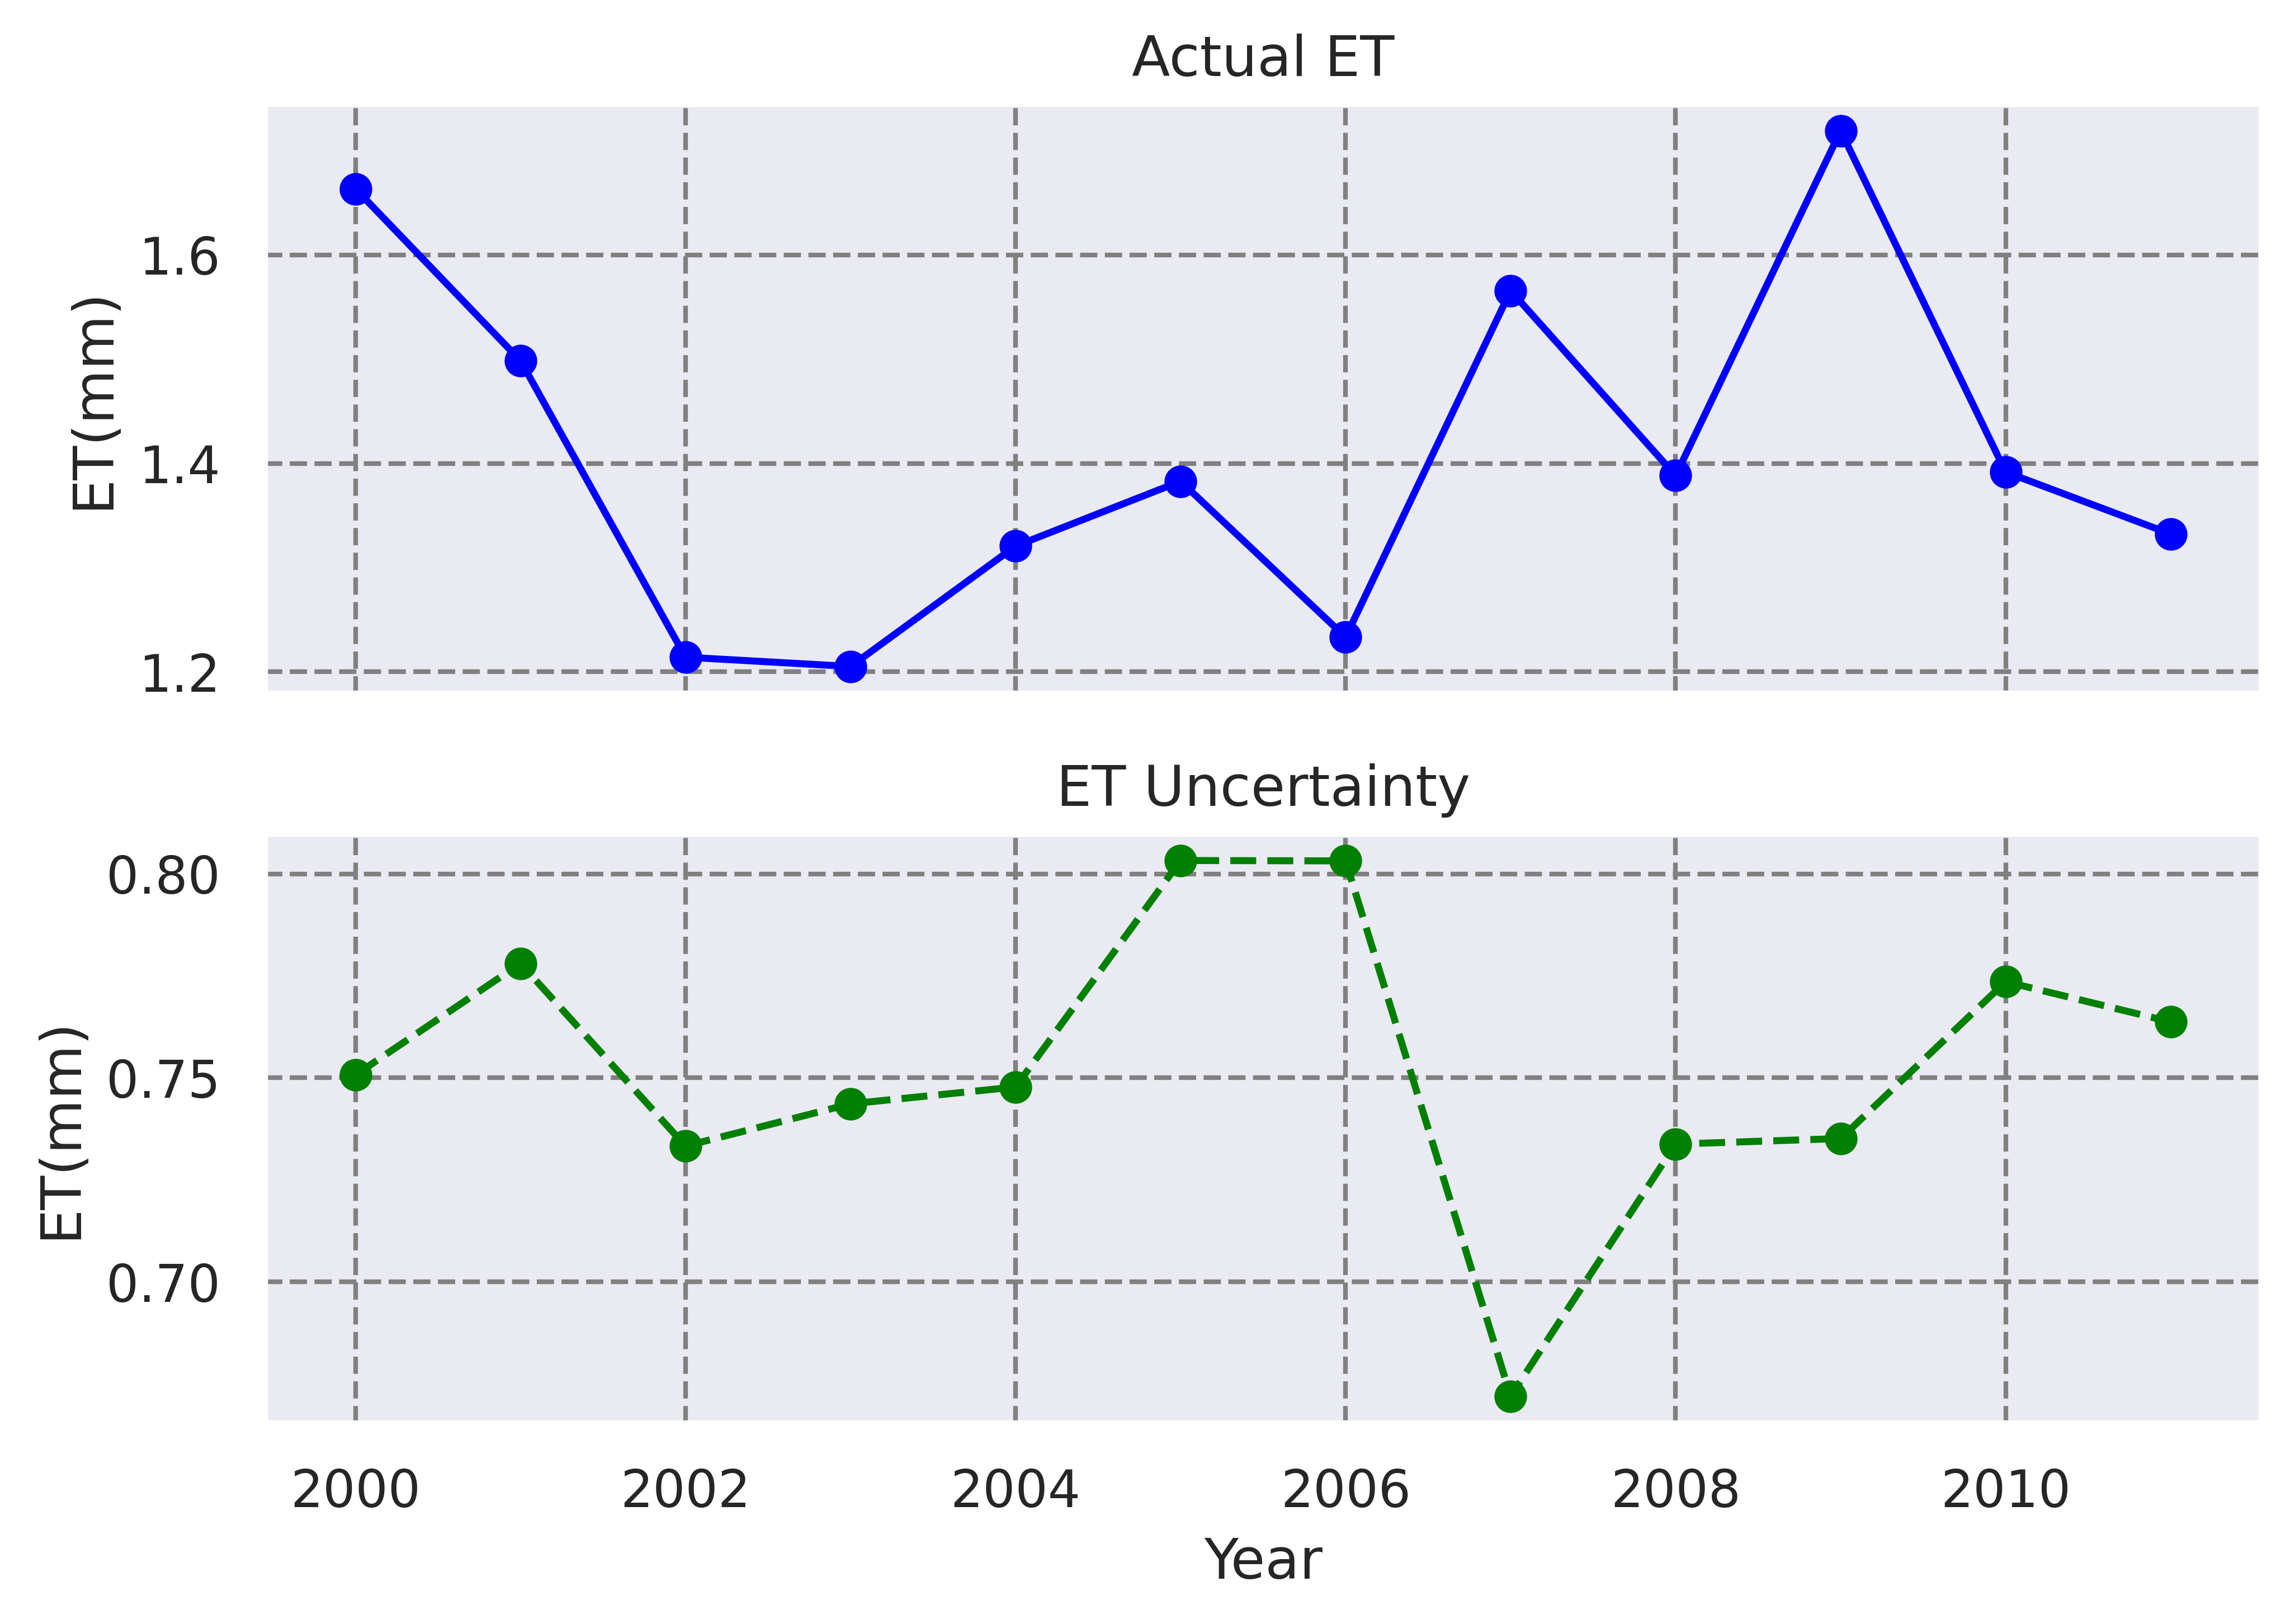

In [ ]:
# Annual aggregated averages comparison between ARD ETa and ARD ETun
ARD_ETa_cleaned_DF = ETa_outliers_df
ARD_ETun_DF = concat_ETun_df

ARD_ETun_DF['Date_string'] = ARD_ETun_DF['Date_string'].astype('datetime64[ns]')
ARD_ETun_DF['Year'] = ARD_ETun_DF['Date_string'].dt.year
ARD_ETun_DF['Month'] = ARD_ETun_DF['Date_string'].dt.month

ETa_annual_means = ARD_ETa_cleaned_DF.groupby(['Year']).agg({'mean_ARD': ['mean']}).reset_index()
ETa_annual_means.columns= [' '.join(col).strip() for col in ETa_annual_means.columns.values]
ETa_annual_means = ETa_annual_means.rename(columns={'mean_ARD mean': 'Mean'})
x1 = ETa_annual_means['Year'].values.tolist()
y1 = ETa_annual_means['Mean'].values.tolist()
# plt.plot(x1,y1)

ETun_annual_mean = ARD_ETun_DF.groupby(['Year']).agg({'mean_ARD':['mean']}).reset_index()
ETun_annual_mean.columns= [' '.join(col).strip() for col in ETun_annual_mean.columns.values]
ETun_annual_mean = ETun_annual_mean.rename(columns={'mean_ARD mean': 'Mean'})
x2 = ETun_annual_mean['Year'].values.tolist()
y2 = ETun_annual_mean['Mean'].values.tolist()
# plt.plot(x2,y2)

fig2, (ax1, ax2) = plt.subplots(2, figsize=(7,5), dpi=600)
this = 'A'
ax1.plot(x1, y1, marker='o', color='blue')
ax1.set_title('Actual ET')
ax1.set_ylabel('ET(mm)')
ax2.plot(x2, y2, marker='o',linestyle='--', color='green')
ax2.set_title('ET Uncertainty')
ax2.set_ylabel('ET(mm)')
for ax in fig2.get_axes():
    ax.label_outer()
plt.xlabel('Year')
plt.tight_layout()
ax1.set_axisbelow(True)
ax1.yaxis.grid(color='gray', linestyle='dashed')
ax1.xaxis.grid(color='gray', linestyle='dashed')
ax2.yaxis.grid(color='gray', linestyle='dashed')
ax2.xaxis.grid(color='gray', linestyle='dashed')
# plt.annotate("A){}".format(this), (1,1))
# plt.annotate("$R^2$: {:.3f}".format(r_value**2), (0.58, 4.45))
# fig2.savefig('/gdrive/MyDrive/ET_report_figs/Ls5_ETa_ETun_comparison.png')

## Monthly annual average ETun for each county/land cover type

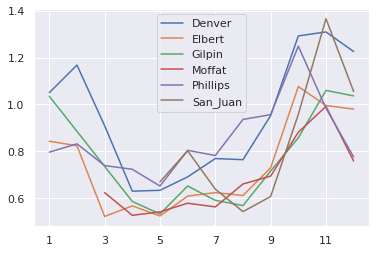

In [ ]:
# monthly aggregated uncertainty averages across land use/counties

ETun_df = concat_ETun_df

ETun_df['Date_string'] = ETun_df['Date_string'].astype('datetime64[ns]')
ETun_df['Year'] = ETun_df['Date_string'].dt.year
ETun_df['Month'] = ETun_df['Date_string'].dt.month

annual_ETun = ETun_df.groupby(['County', 'Month']).agg({'mean_ARD':['mean']}).reset_index().values.tolist()
# print(annual_ETun)
ff = defaultdict(list)
ff_year = defaultdict(list)

for k, year, v in annual_ETun:
  ff[k].append(v)
  ff_year[k].append(year)

sorted(ff.items())
sorted(ff_year.items())
countynames = ff.keys()
fig = plt.figure()

for i_counties in countynames:

  x = ff_year[i_counties]
  y = ff[i_counties]

  plt.plot(x,y)
plt.xticks(np.arange(1, 13, 2))
plt.legend(countynames)


No handles with labels found to put in legend.


0.04004135578698073 0.38170744282948277 0.7863019460501832


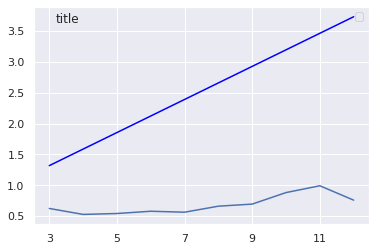

In [ ]:
# Moffat/Shrubland
ETun_df
monthly_ETun = ETun_df.groupby(['County', 'Month']).agg({'mean_ARD':['mean']}).reset_index()
Moffat_mo_ETun = monthly_ETun.loc[monthly_ETun['County'] == 'Moffat']
Moffat_mo_ETun = Moffat_mo_ETun.values.tolist()

ff = defaultdict(list)
ff_year = defaultdict(list)

for k, year, v in Moffat_mo_ETun:
  ff[k].append(v)
  ff_year[k].append(year)

sorted(ff.items())
sorted(ff_year.items())
countynames = ff.keys()
fig = plt.figure()

for i_counties in countynames:

  a = ff_year[i_counties]
  b = ff[i_counties]

plt.plot(a,b)
plt.xticks(np.arange(1, 13, 2))
plt.legend('Moffat')
plt.legend(loc='best')
plt.title("title", x=0.1, y=0.9)

# x_1 = Ls8_annual_means['mean_ARD mean'].values.tolist()
# y_1 = Ls5_annual_means['mean_ARD mean'].values.tolist()
# slope, intercept, r_value, p_value, std_err = stats.linregress(a,b)
# print(slope, intercept, r_value**2, p_value, std_err)
a1 = np.array(a).reshape(-1,1)
b1 = np.array(b).reshape(-1,1)
# regress = LinRegr().fit(a1,b1)
# regress.intercept()
slope, intercept, r, p, se = stats.linregress(a,b)
# print(r**2)
# plt.plot(a, intercept + slope*a, 'r', label='fitted line')
# print('{:.2f} + {:.2f}'.format(slope,intercept))
regress1 = LinRegr().fit(a1,b1)
# plt.scatter(X, Y, color= 'red')
# slope, intercept, r_value, p_value, std_err = stats.linregress(a1,b1)
plt.plot(a1, regress.predict(a1), color = 'blue', label='y={:.2f}x+{:.2f}'.format(slope,intercept))
print(slope,intercept, r)

In [ ]:
# Phillips/cropland
ETun_df
monthly_ETun = ETun_df.groupby(['County', 'Month']).agg({'mean_ARD':['mean']}).reset_index()
Phillips_mo_ETun = monthly_ETun.loc[monthly_ETun['County'] == 'Phillips']
Phillips_mo_ETun = Phillips_mo_ETun.values.tolist()

ff = defaultdict(list)
ff_year = defaultdict(list)

for k, year, v in Phillips_mo_ETun:
  ff[k].append(v)
  ff_year[k].append(year)

sorted(ff.items())
sorted(ff_year.items())
countynames = ff.keys()
fig = plt.figure()

for i_counties in countynames:

  c = ff_year[i_counties]
  d = ff[i_counties]

# plt.plot(c,d)
# plt.xticks(np.arange(1, 13, 2))
# plt.legend(countynames)

<Figure size 432x288 with 0 Axes>

In [ ]:
# Elbert/grassland
ETun_df
monthly_ETun = ETun_df.groupby(['County', 'Month']).agg({'mean_ARD':['mean']}).reset_index()
Elbert_mo_ETun = monthly_ETun.loc[monthly_ETun['County'] == 'Elbert']
Elbert_mo_ETun = Elbert_mo_ETun.values.tolist()

ff = defaultdict(list)
ff_year = defaultdict(list)

for k, year, v in Elbert_mo_ETun:
  ff[k].append(v)
  ff_year[k].append(year)

sorted(ff.items())
sorted(ff_year.items())
countynames = ff.keys()
fig = plt.figure()

for i_counties in countynames:

  e = ff_year[i_counties]
  f = ff[i_counties]

# plt.plot(e,f)
# plt.xticks(np.arange(1, 13, 2))
# plt.legend(countynames)

<Figure size 432x288 with 0 Axes>

In [ ]:
# Gilpin/forest
ETun_df
monthly_ETun = ETun_df.groupby(['County', 'Month']).agg({'mean_ARD':['mean']}).reset_index()
Gilpin_mo_ETun = monthly_ETun.loc[monthly_ETun['County'] == 'Gilpin']
Gilpin_mo_ETun = Gilpin_mo_ETun.values.tolist()

ff = defaultdict(list)
ff_year = defaultdict(list)

for k, year, v in Gilpin_mo_ETun:
  ff[k].append(v)
  ff_year[k].append(year)

sorted(ff.items())
sorted(ff_year.items())
countynames = ff.keys()
fig = plt.figure()

for i_counties in countynames:

  g = ff_year[i_counties]
  h = ff[i_counties]

# plt.plot(g,h)
# plt.xticks(np.arange(1, 13, 2))
# plt.legend(countynames)

<Figure size 432x288 with 0 Axes>

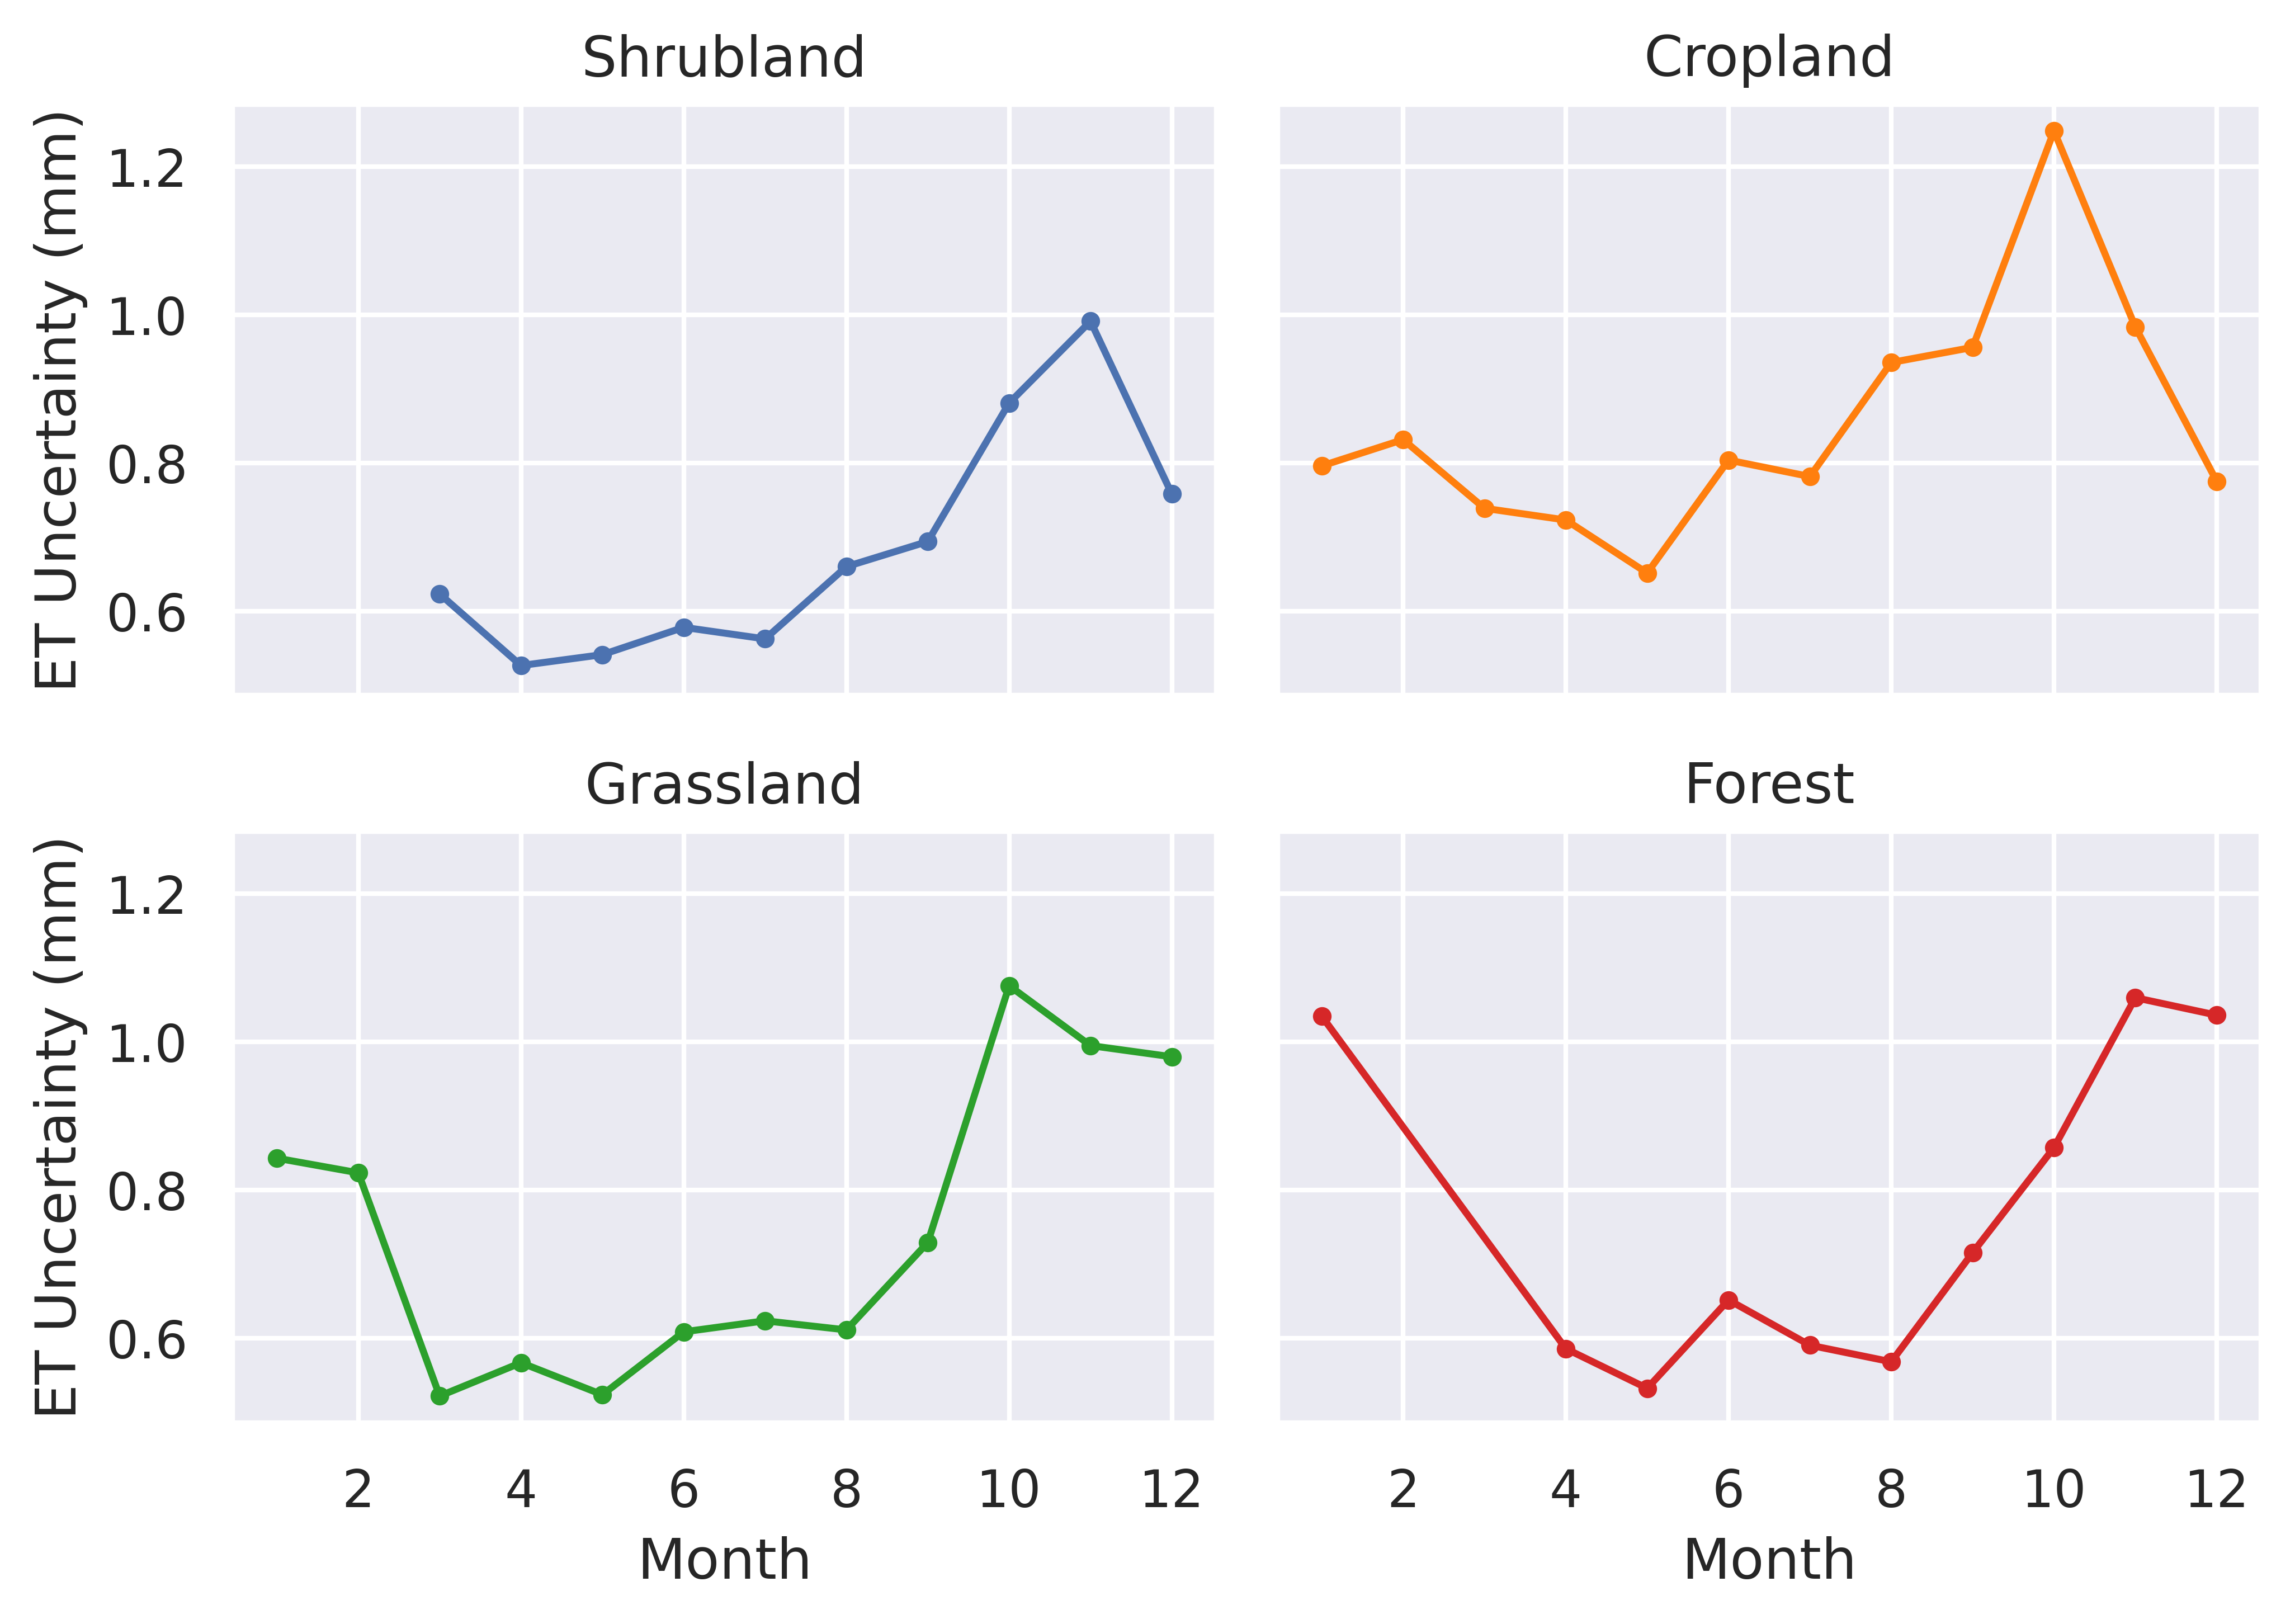

In [ ]:
# Test mulitple plots in one image with subplot
fig_ETun, axs = plt.subplots(2,2, sharey=True, sharex=True, figsize=(7,5), dpi=600)
axs[0, 0].plot(a, b, marker='.')
axs[0, 0].set_title('Shrubland')
axs[0, 1].plot(c, d, 'tab:orange', marker='.')
axs[0, 1].set_title('Cropland')
plt.xticks(np.arange(0, 13, 2))
axs[1, 0].plot(e, f, 'tab:green', marker='.')
axs[1, 0].set_title('Grassland')
axs[1, 1].plot(g, h, 'tab:red', marker='.')
axs[1, 1].set_title('Forest')
for ax in axs.flat:
    ax.set(xlabel='Month', ylabel='ET Uncertainty (mm)')
for ax in axs.flat:
    ax.label_outer()
fig_ETun.tight_layout()
# fig_ETun.savefig('/gdrive/MyDrive/ET_report_figs/ETun_landuse.png')

## ARD and Retrieval ET comparison w/ error bars

,Year,mean_ARD,mean_retrieved_ET
,,mean,mean
0,2000,1.663407,3.952296
1,2001,1.498501,3.608169
2,2002,1.214106,3.464183
3,2003,1.205178,3.471747
4,2004,1.320686,2.994777
5,2005,1.382853,3.039851
6,2006,1.233278,3.065840
7,2007,1.565690,3.881637
8,2008,1.388307,3.343659


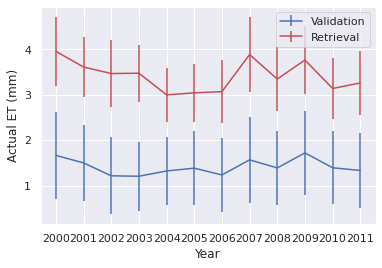

In [ ]:
# ARD ETa and Retrieval ETa overlaid with error bars

Ls5_ETa_df = ETa_outliers_df
# Ls5_ARD_Ret_ETa_err = plt.figure(figsize=(7,5), dpi=600)
Ls5_std_df = Ls5_ETa_df.groupby('Year').agg({'Std_Dev_ARD': ['mean'], 'Std_Dev_retrieved_ET': ['mean']})
Ls5_mean_df = Ls5_ETa_df.groupby('Year').agg({'mean_ARD': ['mean'], 'mean_retrieved_ET': ['mean']})
# plt.plot(Ls_mean_df, linestyle='-', marker='o')
# plt.errorbar(Ls_mean_df['Year'], Ls_mean(ARD_mean))
Ls5_mean_df = Ls5_mean_df.reset_index()
Ls5_mean_df.columns
Ls5_std_df = Ls5_std_df.reset_index()
Ls5_std_df['Std_Dev_ARD']['mean']
plt.errorbar(Ls5_mean_df['Year'], Ls5_mean_df['mean_ARD']['mean'], yerr=Ls5_std_df['Std_Dev_ARD']['mean'], color= 'b') #ARD
plt.errorbar(Ls5_mean_df['Year'], Ls5_mean_df['mean_retrieved_ET']['mean'], yerr=Ls5_std_df['Std_Dev_retrieved_ET']['mean'], color='r') #ET
plt.xticks(np.arange(2000, 2012, 1))
plt.legend(('Validation', 'Retrieval'))
plt.xlabel('Year')
plt.ylabel('Actual ET (mm)')
# Ls5_ARD_Ret_ETa_err.savefig('/gdrive/MyDrive/ET_report_figs/Ls5_ARDandRet_Err.png')
Ls5_std_df.describe()
Ls5_mean_df

# All Landsat

## ETA by Landcover type

In [ ]:


# Moffat/Shrubland
def landtype_fig(LS_dataframe):
  monthly_ETun = LS_dataframe.groupby(['County', 'Month']).agg({'mean_ARD':['mean']}).reset_index()
  Moffat_mo_ETun = monthly_ETun.loc[monthly_ETun['County'] == 'Moffat']
  Moffat_mo_ETun = Moffat_mo_ETun.values.tolist()

  Moffat_dd = defaultdict(list)
  Moffat_year_dd = defaultdict(list)

  for k, year, v in Moffat_mo_ETun:
    Moffat_dd[k].append(v)
    Moffat_year_dd[k].append(year)

  sorted(Moffat_dd.items())
  sorted(Moffat_year_dd.items())
  countynames = Moffat_dd.keys()
  fig = plt.figure()

  for i_counties in countynames:

    a1 = Moffat_year_dd[i_counties]
    b1 = Moffat_dd[i_counties]

  slope, intercept, r, p, se = stats.linregress(a1, b1)
  # print(slope, intercept)

  # Phillips/cropland
  Phillips_mo_ETun = monthly_ETun.loc[monthly_ETun['County'] == 'Phillips']
  Phillips_mo_ETun = Phillips_mo_ETun.values.tolist()

  Phillips_dd = defaultdict(list)
  Phillips_year_dd = defaultdict(list)

  for k, year, v in Phillips_mo_ETun:
    Phillips_dd[k].append(v)
    Phillips_year_dd[k].append(year)

  sorted(Phillips_dd.items())
  sorted(Phillips_year_dd.items())
  countynames = Phillips_dd.keys()
  fig = plt.figure()

  for i_counties in countynames:

    c1 = Phillips_year_dd[i_counties]
    d1 = Phillips_dd[i_counties]

  #polynomial fit with degree = 2

  # # Elbert/grassland
  Elbert_mo_ETun = monthly_ETun.loc[monthly_ETun['County'] == 'Elbert']
  Elbert_mo_ETun = Elbert_mo_ETun.values.tolist()

  Elbert_dd = defaultdict(list)
  Elbert_year_dd = defaultdict(list)

  for k, year, v in Elbert_mo_ETun:
    Elbert_dd[k].append(v)
    Elbert_year_dd[k].append(year)

  sorted(Elbert_dd.items())
  sorted(Elbert_year_dd.items())
  Elbert_name = Elbert_dd.keys()
  fig = plt.figure()

  for i_counties in Elbert_name:

    e1 = Elbert_year_dd[i_counties]
    f1 = Elbert_dd[i_counties]

  # plt.plot(e,f)
  # plt.xticks(np.arange(1, 13, 2))
  # plt.legend(Elbert_name)

  # Gilpin/forest
  Gilpin_mo_ETun = monthly_ETun.loc[monthly_ETun['County'] == 'Gilpin']
  Gilpin_mo_ETun = Gilpin_mo_ETun.values.tolist()

  Gilpin_dd = defaultdict(list)
  Gilpin_year_dd = defaultdict(list)

  for k, year, v in Gilpin_mo_ETun:
    Gilpin_dd[k].append(v)
    Gilpin_year_dd[k].append(year)

  sorted(Gilpin_dd.items())
  sorted(Gilpin_year_dd.items())
  countynames = Gilpin_dd.keys()
  fig = plt.figure()

  for i_counties in countynames:

    g1 = Gilpin_year_dd[i_counties]
    h1 = Gilpin_dd[i_counties]

  # plt.plot(g,h)
  # plt.xticks(np.arange(1, 13, 2))
  # plt.legend(countynames)

  # Test mulitple plots in one image with subplot
  fig_ETa, axs2 = plt.subplots(2,2, sharey=True, sharex=True, figsize=(7,5), dpi=600)
  axs2[0, 0].plot(a1, b1, marker='.')
  axs2[0, 0].set_title('Shrubland')
  axs2[0, 1].plot(c1, d1, 'tab:orange', marker='.')
  axs2[0, 1].set_title('Cropland')
  plt.xticks(np.arange(0, 13, 2))
  axs2[1, 0].plot(e1, f1, 'tab:green', marker='.')
  axs2[1, 0].set_title('Grassland')
  axs2[1, 1].plot(g1, h1, 'tab:red', marker='.')
  axs2[1, 1].set_title('Forest')
  for ax in axs2.flat:
      ax.set(xlabel='Month', ylabel='Actual ET (mm)')
  for ax in axs2.flat:
      ax.label_outer()
  fig_ETa.tight_layout()
  # fig_ETa.savefig('/gdrive/MyDrive/ET_report_figs/ARD7_ETa_landuse.png')
  # return fig_ETa

# landtype_fig(All_Landsats_df)

# merged_wo_outliers_df.describe()
#define function to calculate r-squared


In [ ]:
#### Run this before calling the Landcover function for Landsat 8 ####
# merged_wo_outliers_df.drop(columns=['Std_Dev_ARD', 'area_ARD', 'max_ARD', 'mean_ARD', 'median_ARD', 'min_ARD', 'mean_ARD8', 'Std_Dev_ARD8'], inplace=True)

# merged_wo_outliers_df = merged_wo_outliers_df.rename(columns={'std':'Std_Dev_ARD', 'area_ARD8':'area_ARD', 
#                   'max_ARD8':'max_ARD', 'mean':'mean_ARD', 
#                   'median_ARD8':'median_ARD', 'min_ARD8':'min_ARD'})
# mean_cols = ['mean_ARD', 'mean_ARD8']
# std_cols = ['Std_Dev_ARD8', 'Std_Dev_ARD']
# merged_wo_outliers_df['mean'] = merged_wo_outliers_df[mean_cols].sum(1)
# merged_wo_outliers_df['std'] = merged_wo_outliers_df[std_cols].sum(1)

# merged_wo_outliers_df.loc[merged_wo_outliers_df['County'] == 'Phillips']

In [ ]:
# Combine all Landsat dataframes into one for a total Landsat Dataframe

ls8_to_ls7_df = merged_wo_outliers_df.append(Ls7_Wo_outliers)
# ls8_to_ls7_df
All_Landsats_df = ls8_to_ls7_df.append(ETa_outliers_df)
# (All_Landsats_df['Year'] == 2018) & (All_Landsats_df['County'] == 'Phillips')
# All_Landsats_df.describe() #1.487

In [ ]:
# Total monthly aggeagation of average daily ETA
County_mo_avg = All_Landsats_df.groupby(['Month']).agg({'mean_ARD':['mean']}).reset_index()
County_mo_std = All_Landsats_df.groupby(['Month']).agg({'mean_ARD':['std']}).reset_index()
# Landsat_mo_avg = plt.figure(figsize=(5,5), dpi=600)
plt.errorbar(County_mo_avg['Month'], County_mo_avg['mean_ARD']['mean'], yerr=County_mo_std['mean_ARD']['std'])
plt.xlabel('Month')
plt.ylabel('Actual ET (mm)')
# Landsat_mo_avg.savefig('/gdrive/MyDrive/ET_report_figs/AllLandsat_monthly_means.png')
County_mo_avg

In [ ]:
# Linear regression between single counties and total landsat ETA by monthly averages
single_county = All_Landsats_df.loc[All_Landsats_df['County'] == 'Elbert']
county_agg_month = single_county.groupby('Month').agg({'mean_ARD':['mean']})
# County_mo_avg = County_mo_avg.set_index('Month')
# County_mo_avg = County_mo_avg.drop(labels=[1, 2], axis=0)

# county_agg_month
LsMo = County_mo_avg['mean_ARD']['mean'].values.tolist()
MoAvg = county_agg_month['mean_ARD']['mean'].values.tolist()
slope, intercept, r_value, p_value, std_err = stats.linregress(LsMo, MoAvg)
plt.scatter(County_mo_avg['mean_ARD']['mean'], county_agg_month['mean_ARD']['mean'])
print(slope, intercept, r_value**2, p_value)
print(LsMo)
print(MoAvg)
# county_agg_month

In [ ]:
# ARD ETa and Retrieval ETa overlaid with error bars

# Landsat_ETa = plt.figure(figsize=(8,5), dpi=600)
# plt.figure()
Ls_std_df = All_Landsats_df.groupby('Year').agg({'Std_Dev_ARD': ['mean'], 'Std_Dev_retrieved_ET': ['mean']})
Ls_mean_df = All_Landsats_df.groupby('Year').agg({'mean_ARD': ['mean'], 'mean_retrieved_ET': ['mean']})
# plt.plot(Ls_mean_df, linestyle='-', marker='o')
# plt.errorbar(Ls_mean_df['Year'], Ls_mean(ARD_mean))
Ls_mean_df = Ls_mean_df.reset_index()
# Ls_mean_df.columns
Ls_std_df = Ls_std_df.reset_index()
Ls_std_df['Std_Dev_ARD']['mean']
plt.errorbar(Ls_mean_df['Year'], Ls_mean_df['mean_ARD']['mean'], yerr=Ls_std_df['Std_Dev_ARD']['mean'], color= 'b') #ARD
# plt.errorbar(Ls_mean_df['Year'], Ls_mean_df['mean_retrieved_ET']['mean'], yerr=Ls_std_df['Std_Dev_retrieved_ET']['mean'], color='r') #ET
plt.xticks(np.arange(2000, 2019, 1), rotation = -45)
plt.legend(('Validation', 'Retrieval'))
plt.xlabel('Year')
plt.ylabel('Actual ET (mm)')
# Landsat_ETa.savefig('/gdrive/MyDrive/ET_report_figs/Landsat_ETaARD_Err.png')

This = All_Landsats_df.groupby('Year').agg({'Std_Dev_ARD': ['mean'], 'mean_ARD': ['mean']}).reset_index()
# This['mean_ARD']

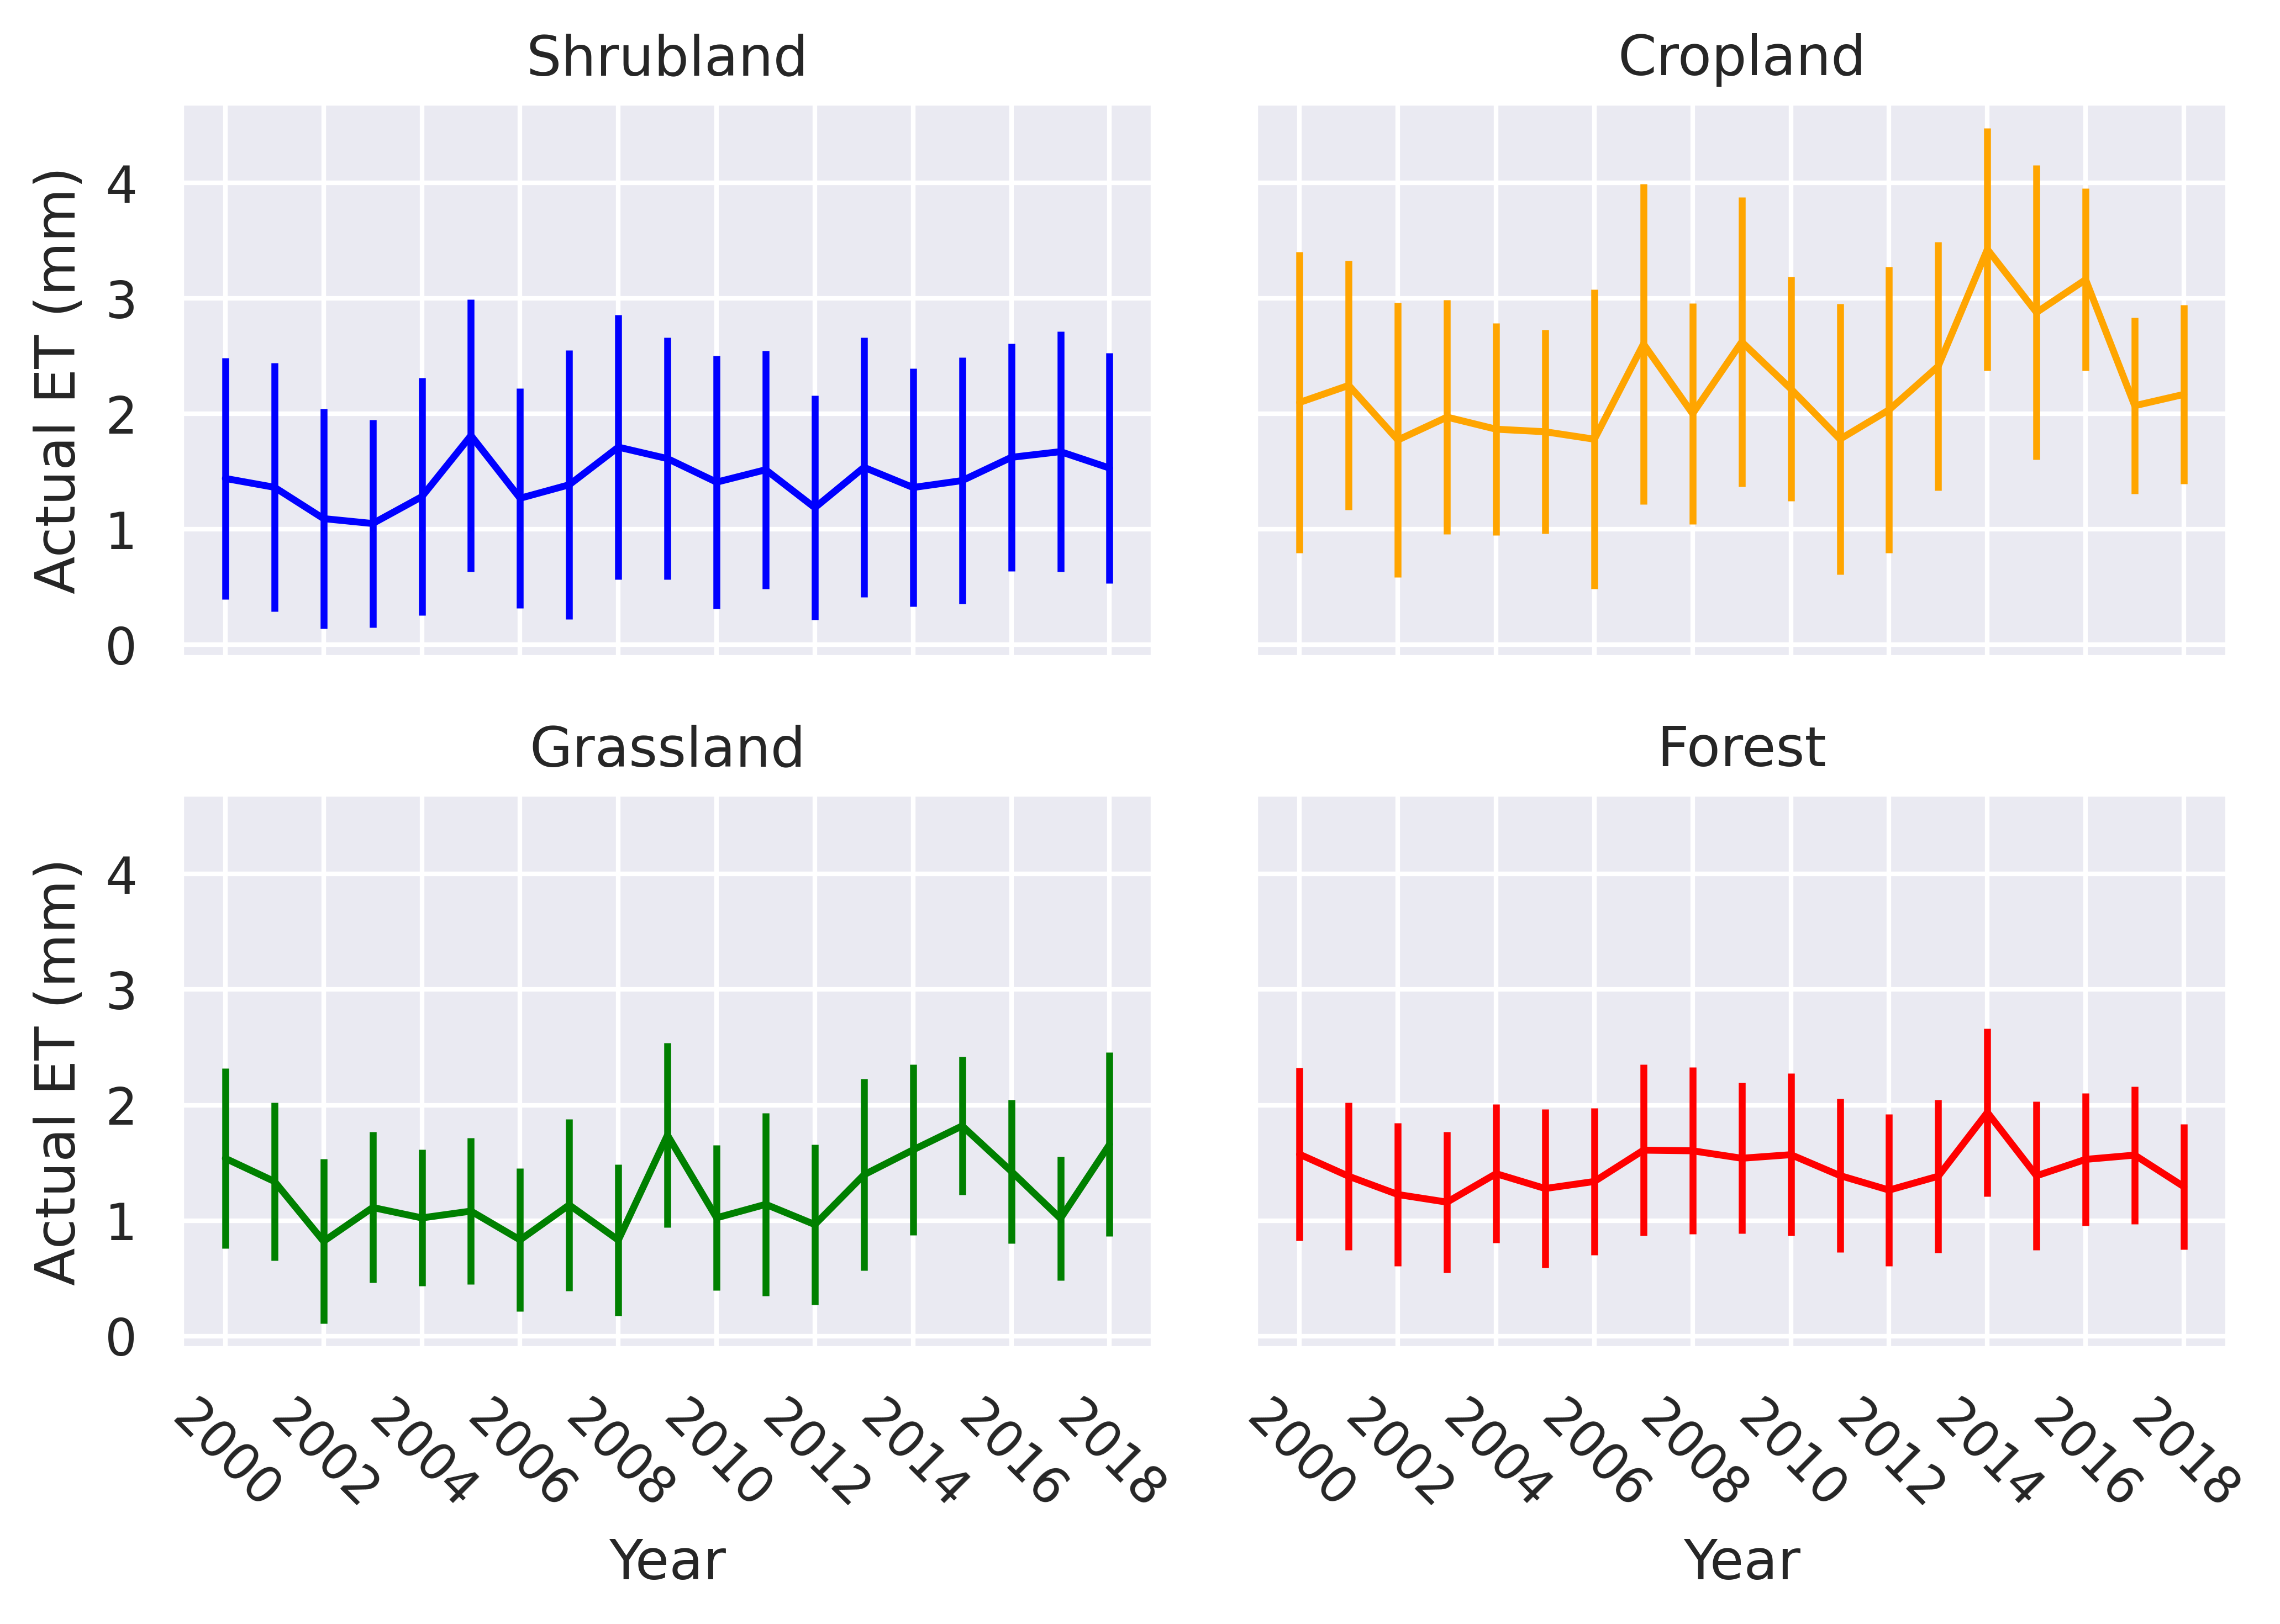

In [ ]:
# Annual aggregated ETA daily values for land cover types

Phillips_df = All_Landsats_df.loc[All_Landsats_df['County'] == 'Phillips']
Elbert_df = All_Landsats_df.loc[All_Landsats_df['County'] == 'Elbert']
Gilpin_df = All_Landsats_df.loc[All_Landsats_df['County'] == 'Gilpin']
Moffat_df = All_Landsats_df.loc[All_Landsats_df['County'] == 'Moffat']

cropland_annual = Phillips_df.groupby('Year').agg({'Std_Dev_ARD': ['mean'], 'mean_ARD': ['mean']}).reset_index()
grassland_annual = Elbert_df.groupby('Year').agg({'Std_Dev_ARD': ['mean'], 'mean_ARD': ['mean']}).reset_index()
forest_annual = Gilpin_df.groupby('Year').agg({'Std_Dev_ARD': ['mean'], 'mean_ARD': ['mean']}).reset_index()
shrubland_annual = Moffat_df.groupby('Year').agg({'Std_Dev_ARD': ['mean'], 'mean_ARD': ['mean']}).reset_index()

county_annaul_avg, axs = plt.subplots(2,2, sharey=True, sharex=True, figsize=(7,5), dpi=600)

axs[0,0].errorbar(shrubland_annual['Year'], shrubland_annual['mean_ARD']['mean'], yerr=shrubland_annual['Std_Dev_ARD']['mean'], color='blue')
axs[0,0].set_title('Shrubland')
axs[0,1].errorbar(cropland_annual['Year'], cropland_annual['mean_ARD']['mean'], yerr=cropland_annual['Std_Dev_ARD']['mean'], color='orange')
axs[0,1].set_title('Cropland')
plt.xticks(np.arange(2000,2019,2),rotation = -45)
axs[1,0].errorbar(grassland_annual['Year'], grassland_annual['mean_ARD']['mean'], yerr=grassland_annual['Std_Dev_ARD']['mean'], color='green')
axs[1,0].set_title('Grassland')
axs[1,0].tick_params(axis='x', rotation=-45)
axs[1,1].errorbar(forest_annual['Year'], forest_annual['mean_ARD']['mean'], yerr=forest_annual['Std_Dev_ARD']['mean'], color='red')
axs[1,1].set_title('Forest')

for ax in axs.flat:
  ax.set(xlabel='Year', ylabel='Actual ET (mm)')
for ax in axs.flat:
  ax.label_outer()

county_annaul_avg.tight_layout()
county_annaul_avg.show()
# file_desc = str(county) + '.png'
## Uncomment to save figure to Drive ##
# county_annaul_avg.savefig('/gdrive/MyDrive/LC_annnual_means_subplot')


In [ ]:
# Total Landsat and Land Cover types dataframes with only growing season months (3 - 9)

Crop_df = Phillips_df[(Phillips_df.Month != 1) & (Phillips_df.Month != 2) & (Phillips_df.Month != 10) & (Phillips_df.Month != 11) & (Phillips_df.Month != 12)]
Grass_df = Elbert_df[(Elbert_df.Month != 1) & (Elbert_df.Month != 2) & (Elbert_df.Month != 10) & (Elbert_df.Month != 11) & (Elbert_df.Month != 12)]
Forest_df = Gilpin_df[(Gilpin_df.Month != 1) & (Gilpin_df.Month != 2) & (Gilpin_df.Month != 10) & (Gilpin_df.Month != 11) & (Gilpin_df.Month != 12)]
Shrub_df = Moffat_df[(Moffat_df.Month != 1) & (Moffat_df.Month != 2) & (Moffat_df.Month != 10) & (Moffat_df.Month != 11) & (Moffat_df.Month != 12)]
All_Landsats_df = All_Landsats_df[(All_Landsats_df.Month != 1) & (All_Landsats_df.Month != 2) & (All_Landsats_df.Month != 10) & (All_Landsats_df.Month != 11) & (All_Landsats_df.Month != 12)]

Crop_mo_df = Crop_df.groupby('Month').agg({'mean_ARD':['mean']}).reset_index()
Grass_mo_df = Grass_df.groupby('Month').agg({'mean_ARD':['mean']}).reset_index()
Forest_mo_df = Forest_df.groupby('Month').agg({'mean_ARD':['mean']}).reset_index()
Shrub_mo_df = Shrub_df.groupby('Month').agg({'mean_ARD':['mean']}).reset_index()
All_Landsats_mo_df = All_Landsats_df.groupby('Month').agg({'mean_ARD':['mean']}).reset_index()

In [ ]:

All_LandsatYrs = Crop_df.groupby('Year').agg({'mean_ARD':['mean']}).reset_index()
Years = All_LandsatYrs['Year'].values.tolist()
AET = All_LandsatYrs['mean_ARD']['mean'].values.tolist()

slope, intercept, r_value, p_value, std_err = stats.linregress(Years, AET)
print('slope {:.2f}, intercept {:.2f}, r_square {:.2f}, p-value {:.2f}, stdErr {:.2f}'.format(slope, intercept, r_value**2, p_value, std_err))
All_LandsatYrs

slope 0.03, intercept -50.46, r_square 0.13, p-value 0.12, stdErr 0.02


,Year,mean_ARD
,,mean
0,2000,2.489251
1,2001,2.979423
2,2002,2.395402
3,2003,2.445506
4,2004,2.492991
5,2005,2.509835
6,2006,1.937507
7,2007,2.911791
8,2008,2.368415


In [ ]:
# Convert each data frame to a numpy array

Crop_array = np.array(Crop_mo_df['mean_ARD'])
Grass_array = np.array(Grass_mo_df['mean_ARD'])
Forest_array = np.array(Forest_mo_df['mean_ARD'])
Shrub_array = np.array(Shrub_mo_df['mean_ARD'])
All_ls_array = np.array(All_Landsats_mo_df['mean_ARD'])


# Crop_mo_df.describe()           # mean 2.519, std 0.545
# Grass_mo_df.describe()          # mean 1.270, std 0.306
# Forest_mo_df.describe()         # mean 1.634, std 0.355
# Shrub_mo_df.describe()          # mean 1.368, std 0.399
# All_Landsats_mo_df.describe()   # meen 1.622, std 0.299

In [ ]:
p = norm.pdf(All_ls_array, 1.622, 0.299)
q_crop = norm.pdf(Crop_array, 2.519, 0.545)
q_grass = norm.pdf(Grass_array, 1.270, 0.306)
q_forest = norm.pdf(Forest_array, 1.634, 0.355)
q_shrub = norm.pdf(Shrub_array, 1.368, 0.399)

print(sum(kl_div(p, q_crop)), 'crop')
print(sum(kl_div(p, q_grass)), 'grass')
print(sum(kl_div(p, q_forest)), 'forest')
print(sum(kl_div(p, q_shrub)), 'shrub')

[2.51337342] crop
[0.07575585] grass
[0.22740874] forest
[1.78972315] shrub


In [ ]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

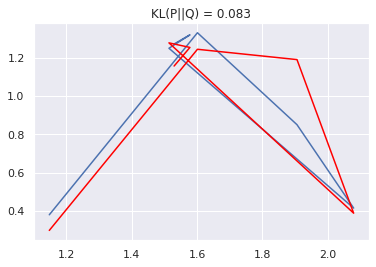

In [ ]:

x7 = All_ls_array

plt.title('KL(P||Q) = %1.3f' % kl_divergence(p, q_grass))
plt.plot(x7, p)
plt.plot(x7, q_grass, c='red')
# print(type(x))

In [ ]:
# ARD regresssion between annual ETa values from LS5 and LS8
# merged_wo_outliers_df
# ETa_outliers_df
Ls8_annual_means = merged_wo_outliers_df.groupby(['Month']).agg({'mean_ARD':['mean']}).reset_index()
Ls8_annual_means.columns = [' '.join(col).strip() for col in Ls8_annual_means.columns.values]
Ls5_annual_means = ETa_outliers_df.groupby(['Month']).agg({'mean_ARD':['mean']}).reset_index()
Ls5_annual_means.columns = [' '.join(col).strip() for col in Ls5_annual_means.columns.values]
# Ls5_annual_means
x_1 = Ls8_annual_means['mean_ARD mean'].values.tolist()
y_1 = Ls5_annual_means['mean_ARD mean'].values.tolist()
slope, intercept, r_value, p_value, std_err = stats.linregress(x_1,y_1)
print(slope, intercept, r_value**2, p_value, std_err)

0.7406764780819676 0.000892495594366105 0.6622821732302647 0.0012773543457478516 0.16725688845440803
